## Importar Librerias

In [ ]:
# Importar librerias
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications import ResNet101
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import seaborn as sns

## Carga de dataset

In [5]:
# Cargar datos
data = pd.read_csv("../files/input/data.csv")

In [6]:
# Datos
tamano = data.shape
print(f"El data set tiene {tamano[0]} registros y {tamano[1]} columnas")
print("Los nombres de las columnas son: ")
for col in data.columns:
    print(col)
data.head()

El data set tiene 127136 registros y 11 columnas
Los nombres de las columnas son: 
BARRIO
COMUNA
DIRECCIÓN
DISEÑO
CLASE
GRAVEDAÑOSSADAÑOSS
DÍA DE LA SEMANA
AÑO
MES
DIA
HORA24


,BARRIO,COMUNA,DIRECCIÓN,DISEÑO,CLASE,GRAVEDAÑOSSADAÑOSS,DÍA DE LA SEMANA,AÑO,MES,DIA,HORA24
0,palenque,robledo,cl 68 cr 87,via,atropello,heridos,domingo,2017,enero,1,12
1,villatina,villa hermosa,cr 16 cl 56,via,choque,heridos,domingo,2017,enero,1,12
2,campo alegre,la américa,cl 44 cr 93,via,choque,heridos,domingo,2017,enero,1,12
3,las granjas,manrique,cr 41 cl 85,cruce,choque,daños,domingo,2017,enero,1,1
4,kennedy,doce de octubre,cr 76 cl 91,via,choque,heridos,domingo,2017,enero,1,1


### Analisis

In [19]:
# Ver información del DataFrame
print(data.info())

# Descripción estadística
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127136 entries, 0 to 127135
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   BARRIO              127136 non-null  object
 1   COMUNA              127136 non-null  object
 2   DIRECCIÓN           127136 non-null  object
 3   DISEÑO              127136 non-null  object
 4   CLASE               127136 non-null  object
 5   GRAVEDAÑOSSADAÑOSS  127136 non-null  object
 6   DÍA DE LA SEMANA    127136 non-null  object
 7   AÑO                 127136 non-null  int64 
 8   MES                 127136 non-null  object
 9   DIA                 127136 non-null  int64 
 10  HORA24              127136 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 10.7+ MB
None
                 AÑO            DIA         HORA24
count  127136.000000  127136.000000  127136.000000
mean     2016.004704      15.710664      11.995163
std         0.814705       8.744525       5

Los tipos de gravedad son: ['heridos' 'daños' 'muertos']


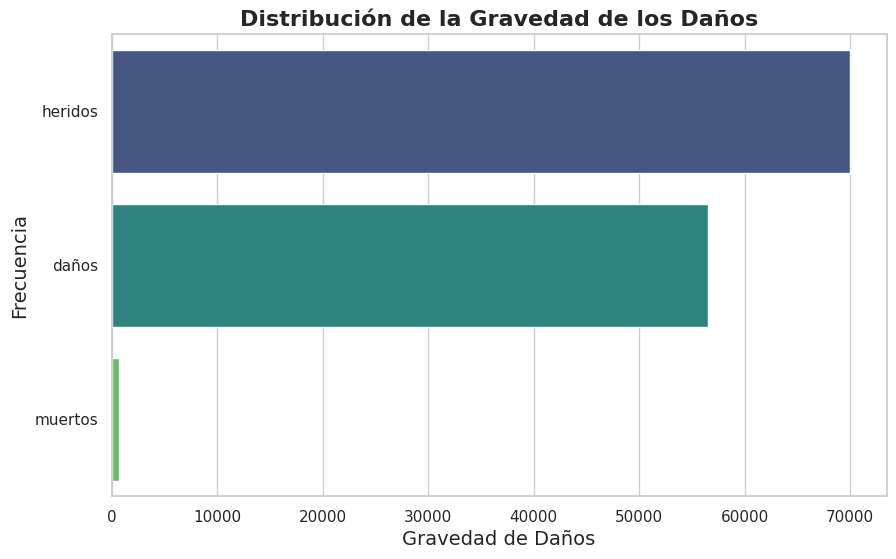

In [ ]:
tiposGravedad = data["GRAVEDAÑOSSADAÑOSS"].unique()
print(f"Los tipos de gravedad son: {tiposGravedad}")

# Crear la gráfica
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(
    y="GRAVEDAÑOSSADAÑOSS", data=data, palette="viridis", hue="GRAVEDAÑOSSADAÑOSS"
)
plt.xlabel("Gravedad de Daños", fontsize=14)
plt.ylabel("Frecuencia", fontsize=14)
plt.title("Distribución de la Gravedad de los Daños", fontsize=16, fontweight="bold")


# Mostrar la gráfica
plt.show()


> Podemos observar que el desbalanceo de las clases!


## Prepocesamiento de datos

In [ ]:
features = [
    "CLASE",
    "DÍA DE LA SEMANA",
    "MES",
    "HORA24",
    "DISEÑO",
    "COMUNA",
]  # Variables independiente
target = "GRAVEDAÑOSSADAÑOSS"  # Variable dependiente

# Codificar la variable objetivo (daños=0, heridos=1, muertos=2)
labelEncoder = LabelEncoder()
data[target] = labelEncoder.fit_transform(data[target])

# One-Hot Encoding de variables categóricas
encoder = OneHotEncoder(drop="first", sparse_output=False)
encodedFeatures = encoder.fit_transform(
    data[["CLASE", "DÍA DE LA SEMANA", "MES", "DISEÑO", "COMUNA"]]
)
encodedFeatureNames = encoder.get_feature_names_out(
    ["CLASE", "DÍA DE LA SEMANA", "MES", "DISEÑO", "COMUNA"]
)

# Crear DataFrame con variables codificadas
dataEncoded = pd.DataFrame(encodedFeatures, columns=encodedFeatureNames)

# Normalizar variables numéricas
scaler = StandardScaler()
dataScaled = pd.DataFrame(scaler.fit_transform(data[["HORA24"]]), columns=["HORA24"])

# Unir todas las características
X = pd.concat([dataEncoded, dataScaled], axis=1)
y = data[target]

In [32]:
# from sklearn.feature_selection import SelectKBest, f_classif

# # Separar datos y etiquetas
# Xk = dataEnconded.drop(columns=target)  # Reemplaza "target" con la variable que intentas predecir
# yk = dataEnconded[target]

# # Seleccionar las K mejores características (ajusta el número según tu dataset)
# selector = SelectKBest(score_func=f_classif, k=20)
# X_new = selector.fit_transform(Xk, yk)

# # Ver las características seleccionadas
# selected_features = X.columns[selector.get_support()]
# print("Características seleccionadas:", list(selected_features))

Características seleccionadas: ['CLASE_caida ocupante', 'CLASE_choque', 'CLASE_otro', 'CLASE_volcamiento', 'DISEÑO_lote', 'DISEÑO_otro', 'DISEÑO_via', 'COMUNA_buenos aires', 'COMUNA_castilla', 'COMUNA_corregimiento de san cristóbal', 'COMUNA_doce de octubre', 'COMUNA_el poblado', 'COMUNA_la candelaria', 'COMUNA_laureles estadio', 'COMUNA_manrique', 'COMUNA_popular', 'COMUNA_robledo', 'COMUNA_san javier', 'COMUNA_santa cruz', 'COMUNA_villa hermosa']


## Red Neuronal

### Dividir datos

In [ ]:
# Dividir en conjunto de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Calcular pesos de clase
classWeights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
classWeightsDict = {i: classWeights[i] for i in range(len(classWeights))}

# Ponderado de cada clase para balancear el target
for clase, pesos in classWeightsDict.items():
    print(f"Clase {clase}: {pesos}")

Clase 0: 0.749992626021296
Clase 1: 0.6059674459617264
Clase 2: 60.97601918465228


### Definir Red neuronal

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 128)                 │           6,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,219 (67.26 KB)

 Trainable params: 16,835 (65.76 KB)

 Non-trainable params: 384 (1.50 KB)

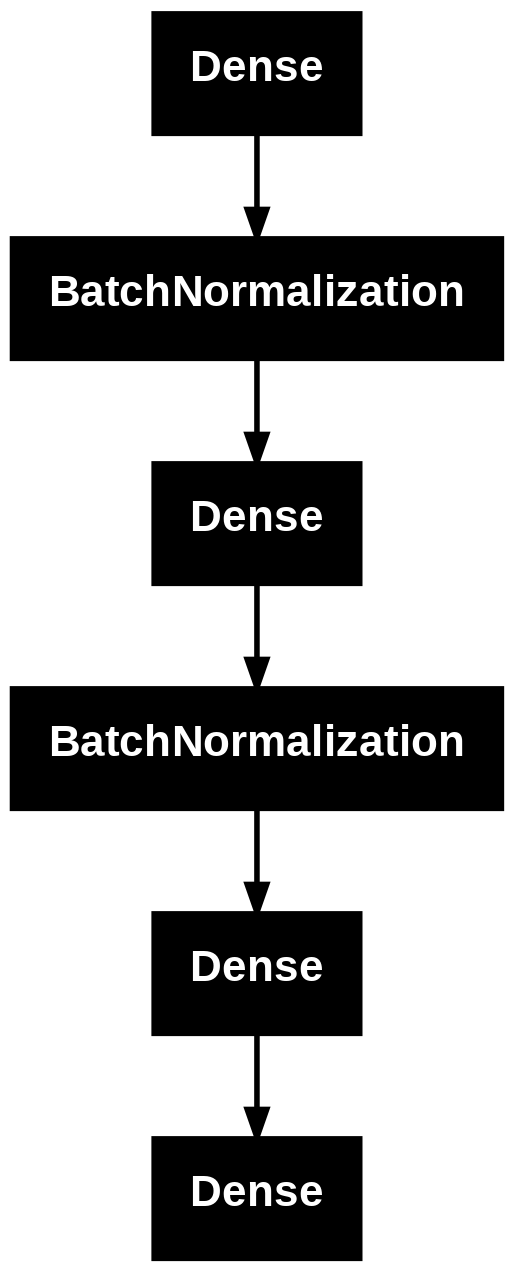

In [ ]:
modelo = keras.Sequential(
    [
        layers.Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation="relu"),
        layers.Dense(3, activation="softmax"),
    ]
)

modelo.summary()

# grafica de la organizacion de las diferentes capas del modelo
tf.keras.utils.plot_model(modelo, show_shapes=False)

### Compilación y definición de callbacks

In [ ]:
# Definir el optimizador
optimizador = Adam(learning_rate=0.001)

# Compilacion
modelo.compile(
    optimizer=optimizador, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Definir callbacks: EarlyStopping y ModelCheckpoint
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitorea la pérdida de validación
    patience=10,  # Número de épocas con mejora mínima para detener el entrenamiento
    restore_best_weights=True,
)  # Restaurar los pesos del modelo con la mejor pérdida de validación

checkpoint_filepath = "./checkpoint.modelo.keras"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
)

# Entrenar el modelo con los pesos de clase
history = modelo.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    class_weight=classWeightsDict,
    callbacks=[early_stopping, model_checkpoint_callback],
)

Epoch 1/20
3179/3179 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6978 - loss: 0.5187 - val_accuracy: 0.7458 - val_loss: 0.5218
Epoch 2/20
3179/3179 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7432 - loss: 0.3711 - val_accuracy: 0.7474 - val_loss: 0.4935
Epoch 3/20
3179/3179 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.7419 - loss: 0.3768 - val_accuracy: 0.7467 - val_loss: 0.5014
Epoch 4/20
3179/3179 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.7421 - loss: 0.3607 - val_accuracy: 0.7465 - val_loss: 0.4980
Epoch 5/20
3179/3179 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7426 - loss: 0.3613 - val_accuracy: 0.7469 - val_loss: 0.5060
Epoch 6/20
3179/3179 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.7436 - loss: 0.3589 - val_accuracy: 0.7465 - val_loss: 0.5182
Epoch 7/20
3179/3179 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.7438 - loss: 0.3547 - val_accuracy: 0.7512 - val_loss: 0.4949
Epoch 8/20
3179/3179 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7448 - loss: 0

Cargar el modelo guardado

In [8]:
# Cargar el modelo guardado como .keras
modelo = tf.keras.models.load_model("./checkpoint.modelo.keras")

## Evaluacion Del Modelo

In [ ]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = modelo.evaluate(X_test, y_test)

print(f"Pérdida en el conjunto de prueba: {loss}")
print(f"Precisión en el conjunto de prueba: {accuracy}")

795/795 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7518 - loss: 0.4828
Pérdida en el conjunto de prueba: 0.4846372604370117
Precisión en el conjunto de prueba: 0.7493707537651062


In [ ]:
# Obtener predicciones del modelo
y_pred = np.argmax(modelo.predict(X_test), axis=1)  # Predicciones en clases
y_true = y_test  # Clases reales

# Calcular métricas de desempeño
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(
    y_true, y_pred, average="weighted"
)  # 'weighted' maneja múltiples clases
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

795/795 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [37]:
# Imprime las métricas
print(f"Exactitud (Accuracy): {accuracy:.4f}")
print(f"Precisión (Precision): {precision:.4f}")
print(f"Sensibilidad (Recall): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Exactitud (Accuracy): 0.7494
Precisión (Precision): 0.8321
Sensibilidad (Recall): 0.7494
F1-Score: 0.7532


### Matriz de confusion

[[10581   196   524]
 [ 5421  8337   230]
 [    2     0   137]]


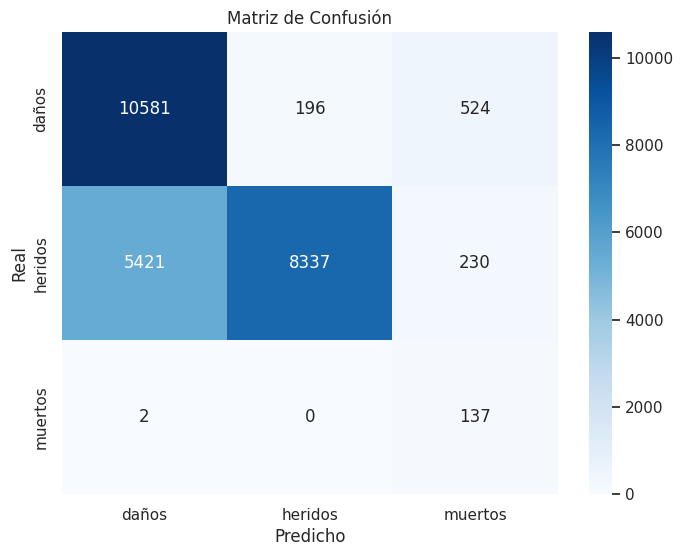

In [ ]:
# Mostrar matriz de confusión
cm = confusion_matrix(y_true, y_pred)
print(cm)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labelEncoder.classes_,
    yticklabels=labelEncoder.classes_,
)
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()